# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая предскажет подходящий тариф.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

# Импорт библиотек

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import xgboost as xgb
from xgboost import XGBClassifier
from tqdm.notebook import tqdm_notebook as tqdm


# Изучим данные

## Общие данные

In [4]:
df = pd.read_csv('users_behavior.csv')

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.

In [6]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [7]:
df.shape

(3214, 5)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [9]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [53]:
need_list_columns = df.drop(columns = 'is_ultra',axis=1).columns

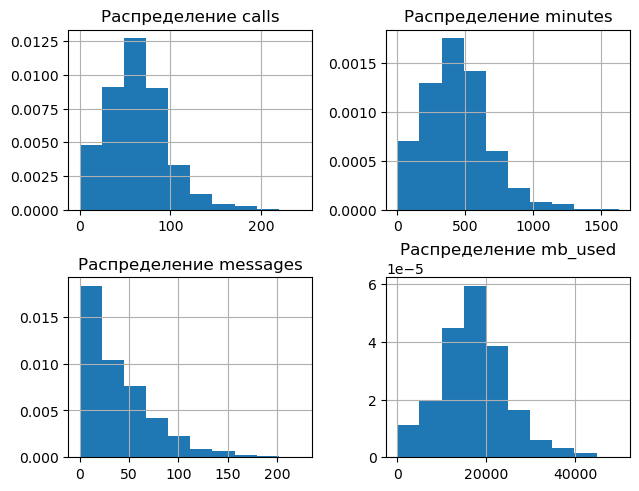

In [106]:
# посмотрим как распределяются признаки
fig = plt.figure(layout="constrained")
ax_dict = fig.subplot_mosaic(
    [
        ["calls", "minutes"],
        ["messages", "mb_used"],
    ],
)

for column in need_list_columns:
    ax = ax_dict[column]
    ax_dict[column].hist(df[column],density=True)
    ax.set_title(f'Распределение {column}')
    ax.grid(True)

__Распределение в разбивке по тарифам__

Text(0.5, 1.0, 'Scatter Matrix')

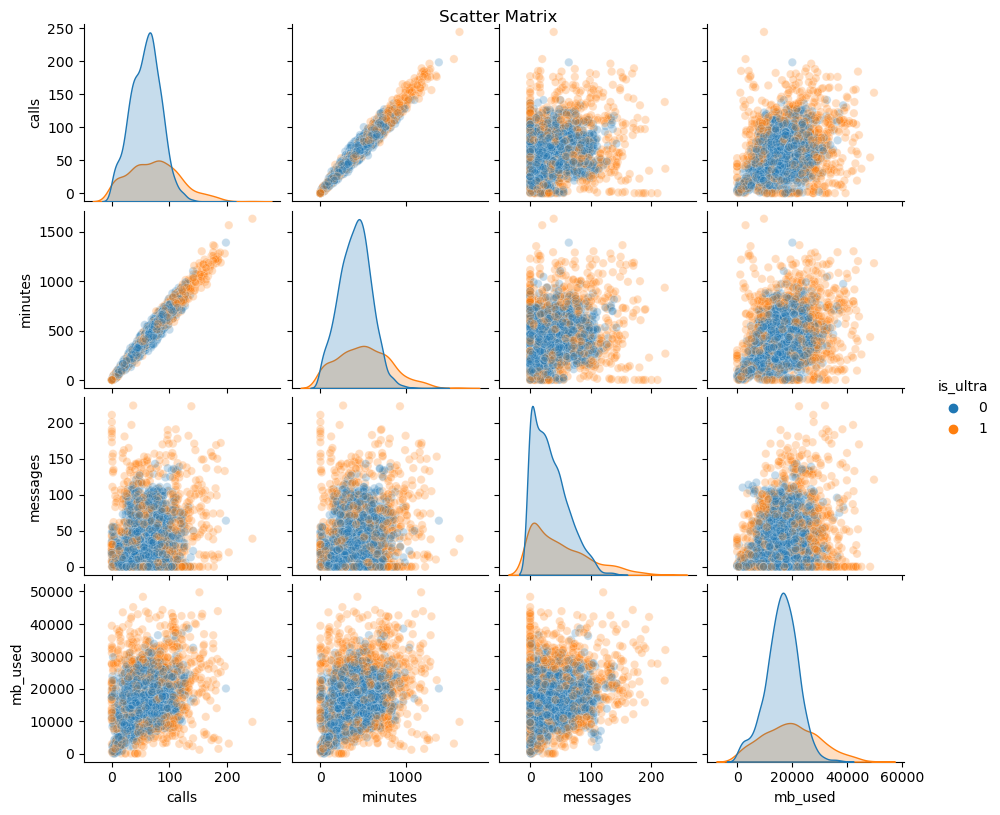

In [230]:
(sns.pairplot(df, vars = df.columns[:-1], hue='is_ultra', plot_kws=dict(alpha=0.25))
    .fig.set_size_inches(10,8) );
plt.suptitle('Scatter Matrix', y=1.)

__Вывод__: в датасете 3214 пользователей. Пропусков нет. Пропорция по тарифам 70/30 - 30% имеют тариф ультра, 70% имеют тариф смарт. Это не совсем пропорциональное разбиение, но и не аномалия, как 95/5. Медианы признаков не сильно отличаются от среднего, поэтому будем предполагать, что аномальных выбросов нет. Большинство признаков имеют Гауссовское распределение

# Смотрим корреляцию

<Axes: >

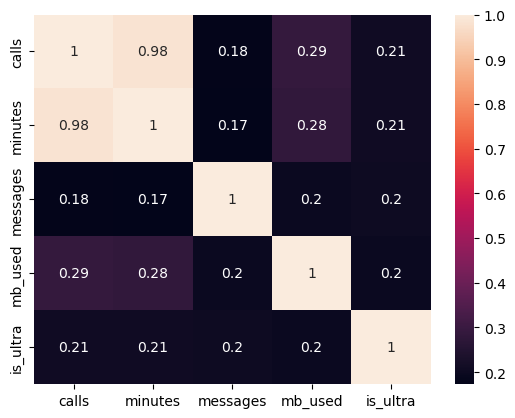

In [125]:
sns.heatmap(df.corr(), annot=True)

__Вывод:__ сильную корреляцию >0.7 не наблюдаем между целевой переменной и признаками. Но видим, что calls и minutes коррелируют между собой, поэтому в дальнейшем прибегне к регуляризации

## Разбейте данные на выборки

In [108]:
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [109]:
#Обозначим переменные
X = df.drop(columns = 'is_ultra', axis = 1)
y = df['is_ultra']

In [115]:
#делим выборки
X_train_val,X_test,y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state = 0, shuffle=True)

In [116]:
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val, test_size=0.25, random_state = 0, shuffle=True)

In [117]:
print(f'all: {len(X)}, train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}')

all: 3214, train: 1928, val: 643, test: 643


__Вывод:__ выборки получились 60/20/20

# Исследуем модели

Так как в рамках данного проекта мы ограничиваемся библиотекой sklearn, то нам необходимо протестировать такие виды моделей, как:
- логистическая регрессия (быстрая, простые параметры мало склончива к переобучению)
- дерево принятия решений (качество должно быть выше лог регресии, но может переобучиться) 
- ансамбль деревьев - случайный лес (должна быть по качеству лучше, но не факт. Такая модель меньше переобучается, чем дерево, но работает достаточно медленно)

## Логистическая регрессия

In [265]:
###Подбор гиперпараметров###
C_list = [0.001,0.1,1,10,100]
penalty_list = ['l1','l2']
solver_list = ['liblinear','saga']
iters = [100,500,1000]

c_results = []
peantrly_results = []
solver_results = []
iter_results = []
accuracy_results = [] 

best_model = None
best_result = 0 

for it in iters:
    for c in C_list:
        for pen in penalty_list:
            for solv in solver_list:
                model = LogisticRegression(C = c, penalty = pen, solver = solv, random_state = 0, max_iter = it )
                model.fit(X_train,y_train)
                predictions=model.predict(X_val)
                result = accuracy_score(y_val, predictions)
                #добавление в списки
                c_results.append(c)
                peantrly_results.append(pen)
                solver_results.append(solv)
                iter_results.append(it)
                accuracy_results.append(result)

                if result>best_result:
                    best_result=result
                    best_model=model
                
print(f'Лучший результат качества модели на валидационной выборке {best_result}')

Лучший результат качества модели на валидационной выборке 0.749611197511664


In [266]:
best_model

LogisticRegression(C=0.1, penalty='l1', random_state=0, solver='liblinear')

In [267]:
pd.set_option('display.float_format', '{:.12f}'.format)

In [268]:
log_results = pd.DataFrame({'c':c_results,
             'penalty':peantrly_results,
             'solver':solver_results,
             'max_iter':it,
             'accuracy':accuracy_results})

In [269]:
log_results.sort_values(by = 'accuracy', ascending = False).head()

,c,penalty,solver,max_iter,accuracy
36,100.000000000000,l1,liblinear,1000,0.749611197512
16,100.000000000000,l1,liblinear,1000,0.749611197512
32,10.000000000000,l1,liblinear,1000,0.749611197512
4,0.100000000000,l1,liblinear,1000,0.749611197512
44,0.100000000000,l1,liblinear,1000,0.749611197512


In [144]:
log_model = best_model

__Вывод:__ пока что модель не дотягивает даже до 0.75. Подбирая гиперпараметры мы увидели, что сразу несколько вариантов дают одинаковое качество. Выбрали первую, которая показала лучший результат

## Дерево принятия решений

In [270]:
###Подбор гиперпараметров### 
best_model = None
best_result = 0 

depth_results = []
leaf_results = [] 
accuracy_results = [] 


for depth in range(1,15,2):
    for min_leaf in range(1,4):
        model = DecisionTreeClassifier(max_depth = depth, min_samples_leaf =min_leaf, random_state =0 )
        model.fit(X_train,y_train)
        predictions=model.predict(X_val)
        result = accuracy_score(y_val, predictions)
        
        depth_results.append(depth)
        leaf_results.append(min_leaf)
        accuracy_results.append(result)
        
        if result>best_result:
            best_result=result
            best_model=model
                
print(f'Лучший результат качества модели на валидационной выборке {best_result}')

Лучший результат качества модели на валидационной выборке 0.8211508553654744


In [271]:
best_model

DecisionTreeClassifier(max_depth=5, random_state=0)

In [272]:
tree_results = pd.DataFrame({'depth':depth_results,
             'min_leaf':leaf_results,
             'accuracy':accuracy_results})

In [275]:
tree_results.sort_values(by = 'accuracy', ascending = False).head()

,depth,min_leaf,accuracy
6,5,1,0.821150855365
3,3,1,0.819595645412
4,3,2,0.819595645412
5,3,3,0.819595645412
8,5,3,0.819595645412


In [158]:
tree_model = best_model

__Вывод:__ качество модели у дерева значительно лучше логистической регресии. Наилучшая глубина - 5, минимальное количество обьектов в листе - 1 

## Ансамбль деревьев

In [277]:
###Подбор гиперпараметров### 
best_model = None
best_result = 0 

n_estimators_results = []
depth_results = [] 
min_samples_leaf_results = [] 
accuracy_results = [] 

for estim in range(2,12,2):
    for depth in (2,5,10,20,50):
        for leaf in (2,5,10,20):
            model = RandomForestClassifier(n_estimators = estim,max_depth = depth, min_samples_leaf = leaf, random_state = 0)
            model.fit(X_train,y_train)
            predictions=model.predict(X_val)
            result = accuracy_score(y_val, predictions)
            
            n_estimators_results.append(estim)
            depth_results.append(depth)
            min_samples_leaf_results.append(leaf)
            accuracy_results.append(result)
            
            if result>best_result:
                best_result=result
                best_model=model
                
print(f'Лучший результат качества модели на валидационной выборке {best_result}')

Лучший результат качества модели на валидационной выборке 0.838258164852255


In [278]:
ensemble_tree_model = best_model

In [280]:
ensemble_results = pd.DataFrame({'depth':depth_results,
             'min_leaf':min_samples_leaf_results,
              'n_estimators':n_estimators_results,                   
             'accuracy':accuracy_results})

In [282]:
ensemble_results.sort_values(by = 'accuracy', ascending = False)

,depth,min_leaf,n_estimators,accuracy
44,5,2,6,0.838258164852
94,20,10,10,0.835147744946
90,10,10,10,0.833592534992
98,50,10,10,0.833592534992
70,10,10,8,0.833592534992
...,...,...,...,...
0,2,2,2,0.783825816485
13,20,5,2,0.777604976672
17,50,5,2,0.777604976672
16,50,2,2,0.769828926905


In [279]:
ensemble_tree_model

RandomForestClassifier(max_depth=5, min_samples_leaf=2, n_estimators=6,
                       random_state=0)

__Вывод:__ качество модели у дерева лучше логистической регресии и дерева принятия решения. Оставили параметры максимальной глубины - 5, минимально в листе по два обьекта, в лесу 6 деревьев

## XGBboost

In [316]:
best_model = None
best_result = 0 

est_results = []
depth_results = [] 
lr_results = [] 
accuracy_results = [] 

for depth in range(1,12,2):
    for est in range(2,21,2):
        for lr in (np.linspace(0.01, 1.00, 10)):
            model = XGBClassifier(n_estimators = est, max_depth = depth, random_state = 0 , learning_rate=lr)
            model.fit(X_train, y_train)
            predictions=model.predict(X_val)
            result = accuracy_score(y_val, predictions)

            
            est_results.append(est)
            depth_results.append(depth)
            lr_results.append(lr)
            accuracy_results.append(result)
            
        
            if result>best_result:
                best_result=result
                best_model=model

print(f'Лучший результат качества модели на валидационной выборке {best_result}')

Лучший результат качества модели на валидационной выборке 0.8506998444790047


In [317]:
xgb_results = pd.DataFrame({'depth':depth_results,
             'learning_rate':lr_results,
              'n_estimators':est_results,                   
             'accuracy':accuracy_results})

In [318]:
xgb_results.sort_values(by = 'accuracy', ascending = False).head()

,depth,learning_rate,n_estimators,accuracy
391,7,0.120000000000,20,0.850699844479
322,7,0.230000000000,6,0.846034214619
381,7,0.120000000000,18,0.846034214619
135,3,0.560000000000,8,0.844479004666
371,7,0.120000000000,16,0.842923794712


In [319]:
xgb_model = best_model

In [320]:
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.12, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=20,
              n_jobs=None, num_parallel_tree=None, ...)

__Вывод:__ xgb показывает лучший результат по качеству с 20 деревьями, глубиной 7 и шагом обучения в 0.12

# Проверка модели на тестовой выборке

## Проверяем модель логистической регрессии на тестовой выборке 

In [162]:
log_predictions = log_model.predict(X_test)

In [166]:
log_result = accuracy_score(y_test, log_predictions)

In [194]:
print(f'Результат качества для модели логистической регрессии на тестовой выборке {log_result}')

Результат качества для модели логистической регрессии на тестовой выборке 0.749611197511664


__Вывод:__ результат идентичный валидационному, но до 75% не дотягивает. 

## Проверяем модель дерево принятия решений на тестовой выборке

In [180]:
tree_predictions = tree_model.predict(X_test)

In [183]:
tree_result = accuracy_score(y_test, tree_predictions)

In [193]:
print(f'Результат качества для модели дерево принятия решений на тестовой выборке {tree_result}')

Результат качества для модели дерево принятия решений на тестовой выборке 0.7838258164852255


__Вывод:__ точность хуже, чем на валидационной выборке, но для нашего проекта проходной бал модель набрала

## Проверяем ансамбль деревьев на тестовой выборке

In [189]:
ensemble_predictions = ensemble_tree_model.predict(X_test)

In [190]:
ensemble_result = accuracy_score(y_test, ensemble_predictions)

In [192]:
print(f'Результат качества для модели ансамбль деревьев на тестовой выборке {ensemble_result}')

Результат качества для модели ансамбль деревьев на тестовой выборке 0.7947122861586314


__Вывод:__ высокое качество показала модель ансамбль деревьев, ее точность 79%

## Проверяем XGB на тестовой выборке

In [321]:
xgb_predictions = xgb_model.predict(X_test)

In [323]:
xgb_result = accuracy_score(y_test, xgb_predictions)

In [324]:
print(f'Результат качества для модели xgb на тестовой выборке {xgb_result}')

Результат качества для модели xgb на тестовой выборке 0.8055987558320373


__Вывод__ Хороший результат. Пока что лучший

# Проверим модель на адекватность

Посмотрим на такие метрики как полнота, точность, f1

## Логистическая регрессия

In [228]:
cm = confusion_matrix(y_test, log_predictions)
tn, fp, fn, tp = cm.ravel() 

print (f'''Для логистической регресси TrueNegative = {tn}
                           FalsePositive = {fp}
                           FalseNegative = {fn}
                           TruePositive = {tp} ''')

precision = precision_score(y_test, log_predictions)
recall = recall_score(y_test, log_predictions)
f1 = f1_score(y_test, log_predictions)
probabilities = log_model.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test,probabilities)

print(f'Точность:{round(precision,2)}, Полнота {round(recall,2)}, Баланс между точностью и полнотой F1 {round(f1,2)}, roc_auc {round(roc,2)}')

Для логистической регресси TrueNegative = 436
                           FalsePositive = 10
                           FalseNegative = 151
                           TruePositive = 46 
Точность:0.82, Полнота 0.23, Баланс между точностью и полнотой F1 0.36, roc_auc 0.68


__Вывод__: реальных обьектов 1 мы смогли обнаружить не так много, тоесть мы чаще угадываем нули, что не удивительно ведь их 70% 

# Дерево принятия решений

In [227]:
cm = confusion_matrix(y_test, tree_predictions)
tn, fp, fn, tp = cm.ravel() 

print (f'''Для дерева решений TrueNegative = {tn}
                           FalsePositive = {fp}
                           FalseNegative = {fn}
                           TruePositive = {tp} ''')

precision = precision_score(y_test, tree_predictions)
recall = recall_score(y_test, tree_predictions)
f1 = f1_score(y_test, tree_predictions)
probabilities = tree_model.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test,probabilities)

print(f'Точность:{round(precision,2)}, Полнота {round(recall,2)}, Баланс между точностью и полнотой F1 {round(f1,2)}, roc_auc {round(roc,2)}')

Для дерева решений TrueNegative = 420
                           FalsePositive = 26
                           FalseNegative = 113
                           TruePositive = 84 
Точность:0.76, Полнота 0.43, Баланс между точностью и полнотой F1 0.55, roc_auc 0.74


__Вывод:__ Дерево принятия решений предсказывает единицы значительно лучше 

## Ансамбль деревьев 

In [226]:
cm = confusion_matrix(y_test, ensemble_predictions)
tn, fp, fn, tp = cm.ravel() 

print (f'''Для дерева решений TrueNegative = {tn}
                           FalsePositive = {fp}
                           FalseNegative = {fn}
                           TruePositive = {tp} ''')

precision = precision_score(y_test, ensemble_predictions)
recall = recall_score(y_test, ensemble_predictions)
f1 = f1_score(y_test, ensemble_predictions)
probabilities = ensemble_tree_model.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test,probabilities)

print(f'Точность:{round(precision,2)}, Полнота {round(recall,2)}, Баланс между точностью и полнотой F1 {round(f1,2)}, roc_auc {round(roc,2)}')




Для дерева решений TrueNegative = 413
                           FalsePositive = 33
                           FalseNegative = 99
                           TruePositive = 98 
Точность:0.75, Полнота 0.5, Баланс между точностью и полнотой F1 0.6, roc_auc 0.77


__Вывод:__ довольно хорошая точность и полнота

## XGB

In [325]:
cm = confusion_matrix(y_test, xgb_predictions)
tn, fp, fn, tp = cm.ravel() 

print (f'''Для дерева решений TrueNegative = {tn}
                           FalsePositive = {fp}
                           FalseNegative = {fn}
                           TruePositive = {tp} ''')

precision = precision_score(y_test, xgb_predictions)
recall = recall_score(y_test, xgb_predictions)
f1 = f1_score(y_test, xgb_predictions)
probabilities = xgb_model.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test,probabilities)

print(f'Точность:{round(precision,2)}, Полнота {round(recall,2)}, Баланс между точностью и полнотой F1 {round(f1,2)}, roc_auc {round(roc,2)}')




Для дерева решений TrueNegative = 419
                           FalsePositive = 27
                           FalseNegative = 98
                           TruePositive = 99 
Точность:0.79, Полнота 0.5, Баланс между точностью и полнотой F1 0.61, roc_auc 0.8


__Вывод:__ опять лучший результат показывает модель с усиленным градиентым бустингом 

# Общий вывод

Мы исследовали три модели: 
- модель логистической регрессии (LogisticRegression)
- модель дерева принятия решений (DecisionTreeClassifier)
- модель ансмабля деревьев (RandomForestClassifier)
- модель XGB (XGBClassifier)

По качеству 0.75 проходят DecisionTreeClassifier и RandomForestClassifier и XGBClassifier, но мы остановимся на XGBClassifier, так как она показала себя лучше всех на тестовых данных. Она показывает умение предугадать более редкий тариф лучше других моделей